In [1]:
%matplotlib inline

# see also, https://github.com/tensorflow/probability/issues/508

import os
import warnings

warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import matplotlib as mpl
from matplotlib import pylab as plt
import matplotlib.dates as mdates
import seaborn as sns

import collections

import numpy as np
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp

from tensorflow_probability import distributions as tfd
from tensorflow_probability import sts

tf.enable_v2_behavior()

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

sns.set_context("notebook", font_scale=1.)
sns.set_style("whitegrid")
%config InlineBackend.figure_format = 'retina'

import plot_functions as pfn
import pandas as pd

tfp.__version__


'0.8.0'

In [2]:
dataset_headers = ['date-time','O','H','L','C']
dataset_dtypes = {'O':'float64','H':'float64','L':'float64','C':'float64'}
dataset_file = '../../../lambda-asset-corpus/adhoc/xauusd_d.csv'
dataset_sep = ','
dataset = pd.read_csv( dataset_file, sep=dataset_sep, names=dataset_headers, dtype=dataset_dtypes )

dataset.tail()


,date-time,O,H,L,C
13588,2020-01-13,1560.71,1561.02,1546.98,1547.89
13589,2020-01-14,1548.36,1548.92,1536.12,1546.44
13590,2020-01-15,1546.36,1558.38,1546.11,1556.29
13591,2020-01-16,1556.42,1558.15,1548.21,1552.48
13592,2020-01-17,1552.54,1561.30,1549.53,1557.07


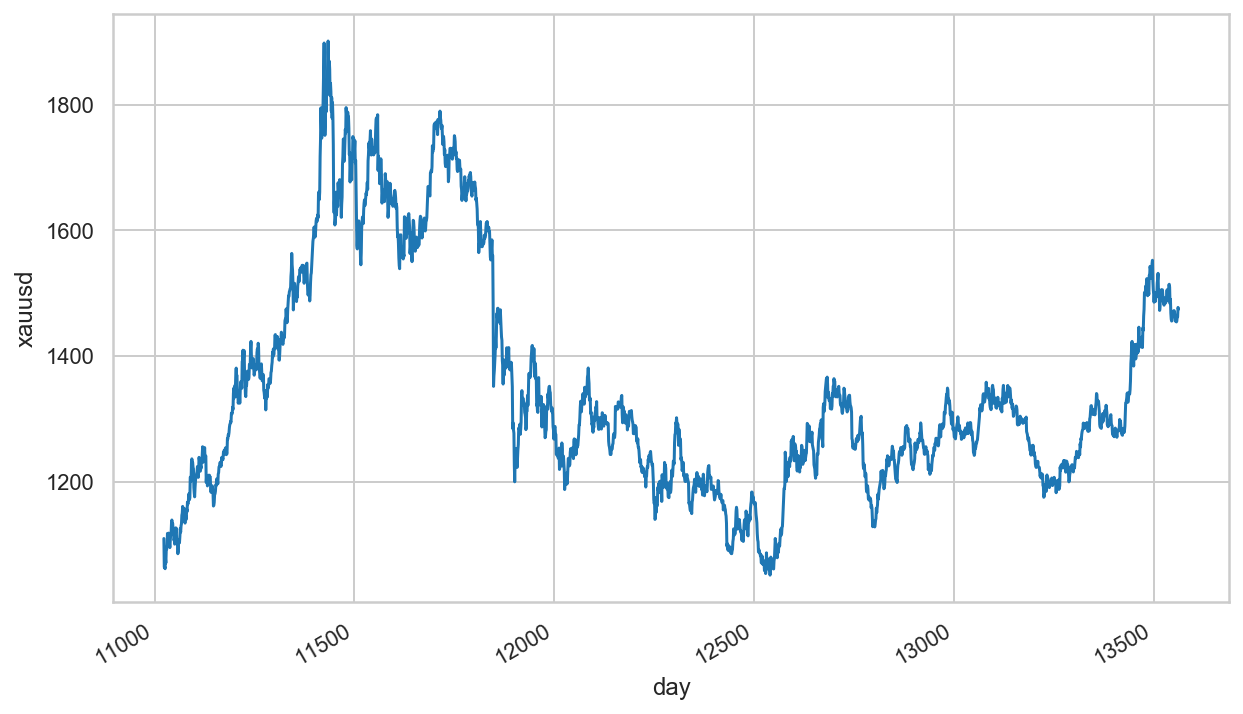

In [8]:
divisible_by_hour=0
num_forecast_steps=30
window=2600+(divisible_by_hour-num_forecast_steps)

close_by_minute=dataset['C'][-window:]
close_by_minute_training_data=close_by_minute[:-num_forecast_steps]
close_minutes=np.arange(start=0,stop=window)

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot( 1, 1, 1 )
ax.plot( close_by_minute_training_data,label="training data")
ax.set_ylabel("xauusd")
ax.set_xlabel("day")
fig.autofmt_xdate()


In [9]:
def build_model( observed_time_series ):
  trend = sts.SemiLocalLinearTrend( 
      observed_time_series=observed_time_series, 
      name='baseline' 
  )
  trading_sessions = sts.Seasonal( 
      num_seasons=10, 
      num_steps_per_season=260, 
      observed_time_series=observed_time_series,
      name='yearly'
  )
  model = sts.Sum( [ trend, trading_sessions, trading_sessions_y ], observed_time_series=observed_time_series )
  return model


In [10]:
close_model = build_model( close_by_minute_training_data )
variational_posteriors = sts.build_factored_surrogate_posterior( model=close_model )


Instructions for updating:
SeedStream has moved to `tfp.util.SeedStream`.


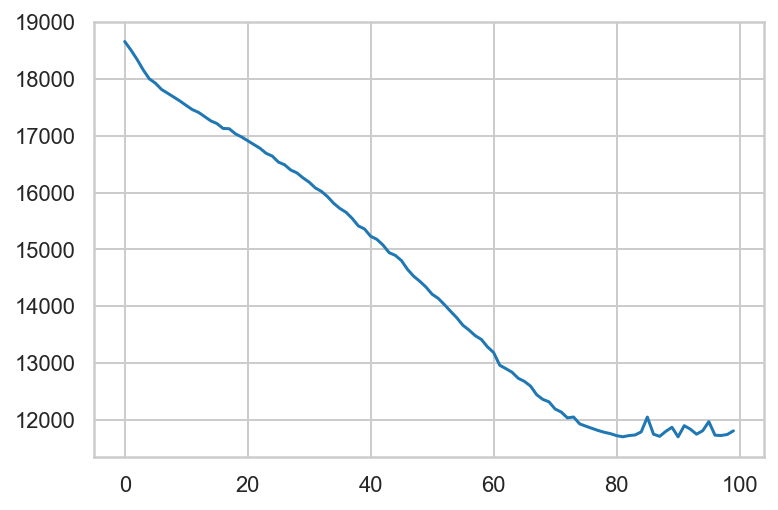

In [11]:
num_variational_steps=int(100)
optimizer = tf.optimizers.Adam( learning_rate=0.05 )

#@tf.function(experimental_compile=True)
def train():
    elbo_loss_curve = tfp.vi.fit_surrogate_posterior( 
        target_log_prob_fn = close_model.joint_log_prob( observed_time_series = close_by_minute_training_data ),
        surrogate_posterior = variational_posteriors,
        optimizer = optimizer,
        num_steps = num_variational_steps )
    return elbo_loss_curve

elbo_loss_curve = train()

plt.plot( elbo_loss_curve )


In [12]:
q_samples = variational_posteriors.sample( 200 )
print( 'Inferred parameters')
for param in close_model.parameters:
    print( "{}: {} +- {}".format( param.name, np.mean(q_samples[param.name], axis=0), np.std(q_samples[param.name], axis=0)))


Inferred parameters
observation_noise_scale: 3.0148544311523438 +- 0.16844412684440613
baseline/_level_scale: 10.547335624694824 +- 0.3201987147331238
baseline/_slope_mean: -2.396242618560791 +- 0.6934194564819336
baseline/_slope_scale: 4.759674549102783 +- 0.15343429148197174
baseline/_autoregressive_coef: 0.25761178135871887 +- 0.03806532546877861
yearly/_drift_scale: 11.452614784240723 +- 12.64067554473877
weekly/_drift_scale: 8.524920463562012 +- 10.21933364868164


In [ ]:
close_forecast_dist = sts.forecast( 
    close_model, 
    observed_time_series=close_by_minute_training_data,
    parameter_samples=q_samples, 
    num_steps_forecast=num_forecast_steps 
)


In [ ]:
num_samples = 30
close_forecast_mean, close_forecast_scale, close_forecast_samples = (
    close_forecast_dist.mean().numpy()[...,0],
    close_forecast_dist.stddev().numpy()[...,0],
    close_forecast_dist.sample(num_samples).numpy()[...,0]
)


In [ ]:
fig,ax=pfn.plot_forecast(
    close_minutes[-10:], 
    close_by_minute[-10:],
    close_forecast_mean, 
    close_forecast_scale, 
    close_forecast_samples,
    title='Close Forecast'
)
ax.axvline( close_minutes[-num_forecast_steps], linestyle="--" )
ax.legend( loc="upper left" )
ax.set_ylabel("close")
ax.set_xlabel("days")
fig.autofmt_xdate()


In [ ]:
component_dists=sts.decompose_by_component( 
    close_model, 
    observed_time_series=close_by_minute, 
    parameter_samples=q_samples
)

close_component_means, close_component_stddevs = (
    {k.name: c.mean() for k, c in component_dists.items()},
    {k.name: c.stddev() for k, c in component_dists.items()}
)

_ = pfn.plot_components( close_minutes, close_component_means, close_component_stddevs )
